In [71]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import math
import numpy as np

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
from typing import Optional, List

from sklearn.datasets import make_moons, make_blobs

# %pip install gin
# import DeepTime.models.modules.inr.INR as INR

# set gpu as default device
torch.set_default_device("cuda")

In [72]:
class RidgeRegressor(nn.Module):
    def __init__(self, lambda_init: Optional[float] =0.):
        super().__init__()
        self._lambda = nn.Parameter(torch.as_tensor(lambda_init, dtype=torch.float))

    def forward(self, reprs: Tensor, x: Tensor, reg_coeff: Optional[float] = None) -> Tensor:
        if reg_coeff is None:
            reg_coeff = self.reg_coeff()
        w, b = self.get_weights(reprs, x, reg_coeff)
        return w, b

    def get_weights(self, X: Tensor, Y: Tensor, reg_coeff: float) -> Tensor:
        batch_size, n_samples, n_dim = X.shape
        ones = torch.ones(batch_size, n_samples, 1, device=X.device)
        X = torch.concat([X, ones], dim=-1)

        if n_samples >= n_dim:
            # standard
            A = torch.bmm(X.mT, X)
            A.diagonal(dim1=-2, dim2=-1).add_(reg_coeff)
            B = torch.bmm(X.mT, Y)
            weights = torch.linalg.solve(A, B)
        else:
            # Woodbury
            A = torch.bmm(X, X.mT)
            A.diagonal(dim1=-2, dim2=-1).add_(reg_coeff)
            weights = torch.bmm(X.mT, torch.linalg.solve(A, Y))

        return weights[:, :-1], weights[:, -1:]

    def reg_coeff(self) -> Tensor:
        return F.softplus(self._lambda)

class GaussianFourierFeatureTransform(nn.Module):
    """
    https://github.com/ndahlquist/pytorch-fourier-feature-networks
    Given an input of size [..., time, dim], returns a tensor of size [..., n_fourier_feats, time].
    """
    def __init__(self, input_dim: int, n_fourier_feats: int, scales: List[int]):
        super().__init__()
        self.input_dim = input_dim
        self.n_fourier_feats = n_fourier_feats
        self.scales = scales

        n_scale_feats = n_fourier_feats // (2 * len(scales))
        assert n_scale_feats * 2 * len(scales) == n_fourier_feats, \
            f"n_fourier_feats: {n_fourier_feats} must be divisible by 2 * len(scales) = {2 * len(scales)}"
        B_size = (input_dim, n_scale_feats)
        B = torch.cat([torch.randn(B_size) * scale for scale in scales], dim=1)
        self.register_buffer('B', B)

    def forward(self, x: Tensor) -> Tensor:
        assert x.dim() >= 2, f"Expected 2 or more dimensional input (got {x.dim()}D input)"
        time, dim = x.shape[-2], x.shape[-1]

        assert dim == self.input_dim, \
            f"Expected input to have {self.input_dim} channels (got {dim} channels)"

        x = torch.einsum('... t n, n d -> ... t d', [x, self.B])
        x = 2 * math.pi * x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)

class INRLayer(nn.Module):
    def __init__(self, input_size: int, output_size: int,
                 dropout: Optional[float] = 0.1):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.linear = nn.Linear(input_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(output_size)

    def forward(self, x: Tensor) -> Tensor:
        out = self._layer(x)
        return self.norm(out)

    def _layer(self, x: Tensor) -> Tensor:
        return self.dropout(torch.relu(self.linear(x)))


class INR(nn.Module):
    def __init__(self, in_feats: int, layers: int, layer_size: int, n_fourier_feats: int, scales: float,
                 dropout: Optional[float] = 0.1):
        super().__init__()
        self.features = nn.Linear(in_feats, layer_size) if n_fourier_feats == 0 \
            else GaussianFourierFeatureTransform(in_feats, n_fourier_feats, scales)
        in_size = layer_size if n_fourier_feats == 0 \
            else n_fourier_feats
        layers = [INRLayer(in_size, layer_size, dropout=dropout)] + \
                 [INRLayer(layer_size, layer_size, dropout=dropout) for _ in range(layers - 1)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.features(x)
        return self.layers(x)


class SIREN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, layers: list, activation_scale: float, dropout: float):
        super().__init__()

        self.activation_scale = activation_scale
        self.dropout = dropout

        self.input_layer = nn.Linear(input_dim, layers[0])
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.output_layer = nn.Linear(layers[-1], output_dim)

    def forward(self, x):
        out = self.input_layer(x)
        out = torch.sin(self.activation_scale * out)
        for layer in self.layers:
            out = layer(out)
            out = torch.sin(self.activation_scale * out)
            out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.output_layer(out)
        return out

def get_initialized_model(input_dim, output_dim, layers, activation_scale, dropout):
    def first_layer_init(m):
        if hasattr(m, 'weight'):
            input_size = m.weight.size(-1)
            m.weight.uniform_(-1 / input_size, 1 / input_size)

    def other_layer_init(m):
        if hasattr(m, 'weight'):
            input_size = m.weight.size(-1)
            m.weight.uniform_(-np.sqrt(6 / input_size) / activation_scale, np.sqrt(6 / input_size) / activation_scale)

    model = SIREN(input_dim, output_dim, layers, activation_scale, dropout)
    with torch.no_grad():
        model.input_layer.apply(first_layer_init)
        model.layers.apply(other_layer_init)
        model.output_layer.apply(other_layer_init)

    return model

def get_lr_weights(x, y, lambda_):
    n_samples, n_features = x.shape
    ones = torch.ones(n_samples, 1)
    x = torch.cat((x, ones), dim=-1)
    
    if n_samples >= n_features:
        A = torch.matmul(x.T, x)
        A.diagonal().add_(lambda_)
        B = torch.matmul(x.T, y)
        weights = torch.linalg.solve(A, B)
    else:
        A = torch.matmul(x, x.T)
        A.diagonal().add_(lambda_)
        weights = torch.matmul(x.T, torch.linalg.solve(A, y))
    w = weights[:-1]
    b = weights[-1]
    return w, b

## Test
# model = get_initialized_model(input_dim=2, output_dim=1, layers=[256, 256, 256, 256], activation_scale=30.0, dropout=0.0)
# x = torch.randn(3, 2)
# y = model(x)
# print(y.shape)  # torch.Size([3, 1])

## Data

(200, 2) (200, 1)


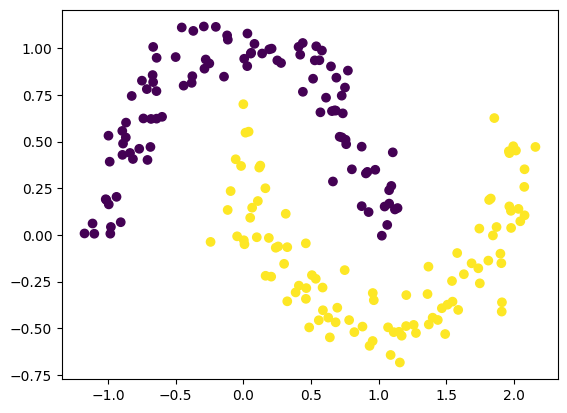

In [73]:
x, y = make_moons(n_samples=200, noise=0.1)
# x, y = make_blobs(n_samples=200, centers=2, n_features=2, random_state=0, cluster_std=0.5)
y = y.reshape(-1, 1).astype(np.float32)
print(x.shape, y.shape)

plt.scatter(x[:, 0], x[:, 1], c=y)

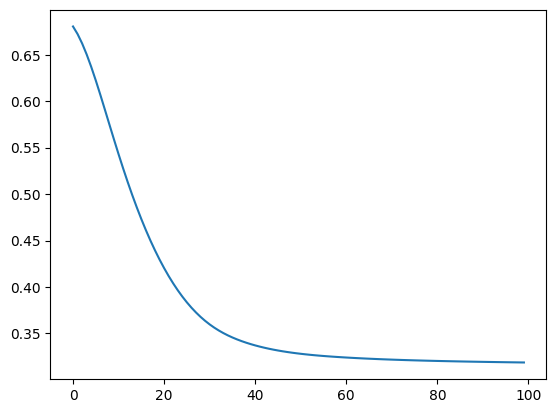

In [74]:
ridge_regressor = RidgeRegressor(lambda_init=0.01)
siren = get_initialized_model(2, 32, [32, 32, 32], 30.0, 0.0)

x = torch.tensor(x, dtype=torch.float32)
y = 2 * torch.tensor(y, dtype=torch.float32) - 1
y_ = (y+1)/2

optimizer = torch.optim.Adam(list(siren.parameters()), lr=1e-4)
n_epochs = 100

losses = []
for i in range(n_epochs):
    # print(x.shape)
    optimizer.zero_grad()
    x_fet = siren(x)
    # print(x_fet.shape)
    w, b = ridge_regressor(x_fet[np.newaxis, ...], y[np.newaxis, ...])
    # print(w.shape, b.shape)
    pred = F.sigmoid(torch.matmul(x_fet, w[0]) + b[0])
    # print(x_fet.shape, y_.shape)
    loss = nn.BCELoss()(pred, y_)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
plt.plot(losses)

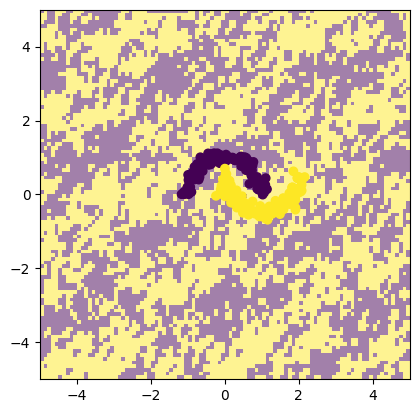

In [75]:
with torch.no_grad():
    x1, x2 = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
    x_grid = np.stack([x1, x2], axis=-1).reshape(-1, 2).astype(np.float32)[np.newaxis, ...]
    x_fet = siren(torch.tensor(x_grid, dtype=torch.float32))
    pred = F.sigmoid(torch.matmul(x_fet, w[0]) + b[0])

    plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=y.detach().cpu().numpy())
    plt.imshow(pred.reshape(100, 100).detach().cpu().numpy()>=0.5, extent=[-5, 5, -5, 5], origin='lower', alpha=0.5)

In [76]:
pred.max(), pred.min()

(tensor(0.8231, device='cuda:0'), tensor(0.1891, device='cuda:0'))

In [77]:
[i for i in dir(torch.func) if "func" in i]

['functional_call', 'functionalize']